# Projeto Spark

A ser realizado em duplas.

Entrega: 6 de dezembro de 2022

## Introdução

Neste projeto vamos construir um classificador Naive-Bayes para determinar o sentimento de um comentário.

## Instalando o ambiente

O jeito mais simples de começar a trabalhar com Spark é instalar um container com tudo pronto! No site https://hub.docker.com/r/jupyter/pyspark-notebook vemos uma imagem Docker que já vem com `pyspark` e `jupyter lab`. Instale a imagem com o comando:

```bash
docker pull jupyter/pyspark-notebook
```

Vamos iniciar o ambiente de trabalho com o comando `docker run`. Para isso precisamos tomar alguns cuidados:

1) Temos que mapear nosso diretorio local de trabalho para um diretório interno do container, de modo que alterações feitas dentro do container (nesta pasta escolhida) sejam gravadas no nosso diretorio local. No container temos um usuário padrão com *username* `jovyan`. No *homedir* desse usuario temos uma pasta vazia `work`, que vai servir como local de mapeamento do nosso diretorio local de trabalho. Podemos então fazer esse mapeamendo com a opção `-v` do comando `docker run` da seguinte forma:

```bash
-v <diretorio>:/home/jovyan/work
```

onde `<diretorio>` representa seu diretorio local de trabalho.

2) Para acessar o `jupyter notebook` e o *dashboard* do Spark a partir do nosso *browser* favorito temos que abrir algumas portas do container com a opção `-p`. As portas são `8888` (para o próprio `jupyter notebook`) e `4040` (para o *dashboard* do Spark). Ou seja, adicionaremos às opções do `docker run`o seguinte:

```bash
-p 8888:8888 -p 4040:4040
```

Desta forma, ao acessar `localhost:8888` na nossa máquina, estaremos acessando o servidor Jupyter na porta 8888 interna do container.

3) Vamos iniciar o container no modo interativo, e vamos especificar que o container deve ser encerrado ao fechar o servidor Jupyter. Faremos isso com as opções `-it` e `-rm`

Portanto, o comando completo que eu uso na minha máquina Linux para iniciar o container é:

```bash
docker run \
    -it \
    --rm \
    -p 8888:8888 \
    -p 4040:4040 \
    -v `pwd`:/home/jovyan/work \
    jupyter/pyspark-notebook


```

Para facilitar a vida eu coloco esse comando em um arquivo `inicia.sh`. Engenheiros, façam do jeito que preferirem!

Agora abra esse notebook lá no container!


## Iniciando o Spark

Vamos iniciar o ambiente Spark. Para isso vamos:

1) Criar um objeto de configuração do ambiente Spark. Nossa configuração será simples: vamos especificar que o nome da nossa aplicação Spark é "Minha aplicação", e que o *master node* é a máquina local, usando todos os *cores* disponíveis. Aplicações reais de Spark são configuradas de modo ligeiramente diferente: ao especificar o *master node* passamos uma URL real, com o endereço do nó gerente do *cluster* Spark.

2) Vamos criar um objeto do tipo `SparkContext` com essa configuração

In [1]:
import pyspark

conf = pyspark.SparkConf()
conf.setAppName('Minha aplicação')
conf.setMaster('local[*]')

sc = pyspark.SparkContext(conf=conf)

O `SparkContext` é a nossa porta de entrada para o cluster Spark, ele será a raiz de todas as nossas operações com o Spark.

In [2]:
sc

<SparkContext master=local[*] appName=Minha aplicação>

O link acima provavelmente não funcionará porque ele se refere à porta 4040 interna do container (portanto a URL está com endereço interno). Porém fizemos o mapeamento da porta 4040 interna para a porta 4040 externa, logo você pode acessar o *dashboard* do Spark no endereço http://localhost:4040

<center><img src="./spark_dashboard.png" width=800/></center>

## Lendo os dados

Vamos começar lendo o arquivo de reviews e gravando o resultado em formato pickle, mais amigável.

In [3]:
def parse_line(line):
    parts = line[1:-1].split('","')
    sentiment = int(parts[0])
    title = parts[1].replace('""', '"')
    body = parts[2].replace('""', '"')
    return (sentiment, title, body)

rdd = sc.textFile('train.csv').map(parse_line)

In [4]:
rdd.count()

3600000

In [5]:
rdd.take(1)

[(2,
  'Stuning even for the non-gamer',
  'This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^')]

Agora vamos gravar no formato pickle, para facilitar os trabalhos futuros. Após gravar o arquivo, não mais rode as células desta primeira etapa!

In [6]:
# rdd.saveAsPickleFile('reviews.pickle')

## Um classificador Naive-Bayes

Vamos ler o arquivo pickle gravado anteriormente:

In [7]:
rdd = sc.pickleFile('reviews.pickle')

In [8]:
rdd.count()

3600000

In [9]:
rdd.take(1)

[(2,
  'Stuning even for the non-gamer',
  'This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^')]

Agora, complete as tarefas em sequencia para construir o classificador Naive-Bayes:

### Fase 1

### Tarefa

Construa uma função que recebe um RDD no formato do RDD original e retorna um RDD no qual cada item é um par (palavra, contagem).

### OBS:

`flatmap` reduz a dimensionalidade do array e itera sobre cada elemento, onde em seguida aplica a função. Já o `map` itera diretamente.

Ex: 

Dado o array arr = ["1,2,3,4", "2,4,2,4", "3,2,3,4", "4,7,4,2", "5,3,7,8"]

<u>Map</u>

[["1,2,3,4"], [...], [...], [...], ["5,3,7,8"]] ---> O primeiro elemento seria "1,2,3,4" e assim sucessivamente --> Em seguida aplica função

<u>FlatMap</u>

[["1,2,3,4"], [...], [...], [...], ["5,3,7,8"]] ---> reduz o array n x n para 1 x n: ["1", "2", "3", ..., "5", "3", "7", "8"] ---> Em seguida aplica função



In [10]:
import string

In [11]:
def remove_ponctuation(r):
    title = r[1].translate(str.maketrans('', '', string.punctuation))
    body = r[2].translate(str.maketrans('', '', string.punctuation))
    return title, body

def word_separation(review):
    t, b = remove_ponctuation(review)
    corpus = t.split() + b.split()
    return corpus

In [12]:
# Dessa maneira, estamos tendo acesso às palavras em listas pra cada review.
rdd\
    .map(word_separation).take(1)

[['Stuning',
  'even',
  'for',
  'the',
  'nongamer',
  'This',
  'sound',
  'track',
  'was',
  'beautiful',
  'It',
  'paints',
  'the',
  'senery',
  'in',
  'your',
  'mind',
  'so',
  'well',
  'I',
  'would',
  'recomend',
  'it',
  'even',
  'to',
  'people',
  'who',
  'hate',
  'vid',
  'game',
  'music',
  'I',
  'have',
  'played',
  'the',
  'game',
  'Chrono',
  'Cross',
  'but',
  'out',
  'of',
  'all',
  'of',
  'the',
  'games',
  'I',
  'have',
  'ever',
  'played',
  'it',
  'has',
  'the',
  'best',
  'music',
  'It',
  'backs',
  'away',
  'from',
  'crude',
  'keyboarding',
  'and',
  'takes',
  'a',
  'fresher',
  'step',
  'with',
  'grate',
  'guitars',
  'and',
  'soulful',
  'orchestras',
  'It',
  'would',
  'impress',
  'anyone',
  'who',
  'cares',
  'to',
  'listen']]

In [13]:
# Queremos as palavras de TODOS reviews contidas em UMA lista apenas. Usando o flatMap, atingimos esse objetivo.
rdd\
    .flatMap(word_separation).take(5)

['Stuning', 'even', 'for', 'the', 'nongamer']

In [14]:
# Ao invés de reduzir a um único valor como o reduce, o reduceByKey reduz a uma lista de tuplas, onde cada tupla seria um par (chave, valor)
# reduceByKey(lambda accumulatedValue, currentValue: accumulatedValue + currentValue)
def count_word(_rdd):
    cw = _rdd \
        .flatMap(word_separation) \
        .map(lambda x: (x,1)) \
        .reduceByKey(lambda x,y: x+y)
    return cw

In [15]:
count = count_word(rdd)
count.take(3)

[('out', 782684), ('like', 965412), ('Stars', 7413)]

### Tarefa

Construa uma função que recebe o RDD (palavra, contagem) construido anteriormente e retorna um RDD no qual cada item é um par (palavra, $\log_{10}\left(c \, / \, T\right)$), onde $c$ é a contagem daquela palavra e $T$ é a soma das contagens de palavra.

In [16]:
T = count.map(lambda x: x[1]).sum()
T

281417436

In [17]:
import numpy as np 

def count_log(_rdd):
    T = _rdd.map(lambda x: x[1]).sum() 
    cl = _rdd.map(lambda x: (x[0], np.log10(x[1]/T)))
    return cl 

In [18]:
cnt_log = count_log(count)
cnt_log.take(3)

[('out', -2.555764545999455),
 ('like', -2.464638309090318),
 ('Stars', -4.579357001733198)]

#### Tarefa

Separe o RDD original em dois RDDs: o dos reviews positivos e o dos negativos. Em seguida, use as funções anteriores para construir RDDs que contem os pares (palavra, $\log_{10}\left(c \, / \, T\right)$)

In [46]:
negative_rdd = rdd.filter(lambda x: x[0] == 1)
positive_rdd = rdd.filter(lambda x: x[0] == 2)

negative_word_count = count_word(negative_rdd)
positive_word_count = count_word(positive_rdd)

#Construindo os pares
neg_rdd = count_log(negative_word_count)
pos_rdd = count_log(positive_word_count)           

In [47]:
neg_rdd.take(10)

[('book', -2.211221702630697),
 ('family', -3.807023215978198),
 ('belief', -4.665473902486612),
 ('wasting', -4.2812006051107865),
 ('out', -2.5264979053685646),
 ('spelling', -4.759060697706053),
 ('item', -3.245638998355628),
 ('immediateHere', -8.16474848437883),
 ('timbre', -6.25626346550018),
 ('24', -4.331856539619039)]

In [48]:
pos_rdd.take(10)

[('out', -2.5897644969597597),
 ('like', -2.4747862361501625),
 ('Stars', -4.508101761741771),
 ('book', -2.152625286374434),
 ('let', -3.654054005277595),
 ('When', -3.430267166329418),
 ('4', -3.361265083450195),
 ('family', -3.3543939677236634),
 ('Steven', -4.904390066090987),
 ('start', -3.506996488996986)]

### Tarefa

Use o `.fullOuterJoin()` dos RDDs para construir um RDD unificado, no qual cada item é da forma (palavra, log_prob_positivo, log_prob_negativo). "Baixe" esse resultado final usando `.collect()`.

In [22]:
pos_rdd.fullOuterJoin(neg_rdd).map(lambda x: (x[0], x[1][1], x[1][0])).take(1)

[('family', -3.3543939677236634, -3.807023215978198)]

In [23]:
unified_rdd = pos_rdd \
                .fullOuterJoin(neg_rdd) \
                .map(lambda x: (x[0], x[1][1], x[1][0]))
pos_neg_list = unified_rdd.collect()

#### Tarefa

Para uma dada string, determine se ela é um review positivo ou negativo usando os RDDs acima. Lembre-se de como funciona o classificador Naive-Bayes: http://stanford.edu/~jurafsky/slp3/slides/7_NB.pdf, consulte tambem suas notas de aula de Ciência dos Dados!

In [24]:
def naive_bayes(review, pos_neg):
    title, body = remove_ponctuation(review)
    corpus = title.split() + body.split()
    pos = 0
    neg = 0
    for word in corpus:
        for tup in pos_neg:
            if word == tup[0]:
                if tup[1] != None:
                    pos += tup[1]
                if tup[2] != None:
                    neg += tup[2]
    if pos > neg:
        return 2
    else:
        return 1

In [25]:
#Montando uma base para testar
teste = rdd.sample(False, 0.1).map(lambda x: (x[0], x[2])).take(1000)
teste[:3]

[(2,
  'This soundtrack is my favorite music of all time, hands down. The intense sadness of "Prisoners of Fate" (which means all the more if you\'ve played the game) and the hope in "A Distant Promise" and "Girl who Stole the Star" have been an important inspiration to me personally throughout my teen years. The higher energy tracks like "Chrono Cross ~ Time\'s Scar~", "Time of the Dreamwatch", and "Chronomantique" (indefinably remeniscent of Chrono Trigger) are all absolutely superb as well.This soundtrack is amazing music, probably the best of this composer\'s work (I haven\'t heard the Xenogears soundtrack, so I can\'t say for sure), and even if you\'ve never played the game, it would be worth twice the price to buy it.I wish I could give it 6 stars.'),
 (2,
  'This was a great book,I just could not put it down,and could not read it fast enough. Boy what a book the twist and turns in this just keeps you guessing and wanting to know what is going to happen next. This book makes you 

In [26]:
print(naive_bayes(teste[0][1], pos_neg_list))
print(naive_bayes(teste[1][1], pos_neg_list))
print(naive_bayes(teste[2][1], pos_neg_list))

1
1
1


### Fase 2

Agora que temos um classificador Naive-Bayes, vamos explorá-lo um pouco:

### Tarefa

Quais são as 100 palavras que mais indicam negatividade, ou seja, onde a diferença entre a probabilidade da palavra no conjunto dos comentários negativos e positivos é máxima? E quais as 100 palavras de maior positividade? Mostre os resultados na forma de *word clouds*.

In [49]:
# (palavra, log_prob_positivo, log_prob_negativo) 

# Devido a falta de smoothing, tivemos alguns valores de probabilidade None logo, vamos excluí-los com o filter

negativity = unified_rdd \
                .filter(lambda x: x[1] != None and x[2] != None) \
                .map(lambda x: (x[0], x[2] - x[1])) \
                .sortBy(lambda x: x[1], ascending = False) \
                .take(100)

positivity = unified_rdd \
                .filter(lambda x: x[1] != None and x[2] != None) \
                .map(lambda x: (x[0], x[1] - x[2])) \
                .sortBy(lambda x: x[1], ascending = False) \
                .take(100)

In [50]:
negativity[:5]

[('Worthless', 2.3249416489503156),
 ('SecuROM', 2.252056461008654),
 ('Unimpressed', 2.245252752953709),
 ('Unsatisfactory', 2.242960956174124),
 ('Plodding', 2.233670880403894)]

In [51]:
positivity[:5]

[('Bookwatch', 2.147444200305956),
 ('Excelente', 2.069597193347396),
 ('Exelent', 1.9779835201492881),
 ('McVay', 1.9419858668777694),
 ('Musthave', 1.9311279392895608)]

In [52]:
!pip install WordCloud

In [53]:
#https://www.datacamp.com/tutorial/wordcloud-python

from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
# Precisamos passar as palavras em uma string única, porque o wordcloud tem isso como param

negativity_text = " ".join(review[0] for review in negativity)
positivity_text = " ".join(review[0] for review in positivity)

print("------- Common words associated to negativity -------")
print(negativity_text + "\n")
print("------- Common words associated to positivity -------")
print(positivity_text + "\n")

------- Common words associated to negativity -------
Worthless SecuROM Unimpressed Unsatisfactory Plodding Substandard Unwatchable Disapointment Unfunny Amateurish Unreliable Dreck Inane Uninspired Unimaginative Leaked Defective Poorly Dissatisfied Tripe Dissapointment Atrocious RUBBISH Disappointing Unlistenable Unusable Rehashed Disappointment Stilted CDilla Misrepresentation zerostar Uninteresting DISAPOINTMENT Dissappointing JUNK Disapointing E18 Overwritten WASTE Unacceptable Unsafe Nauseating Flaky Ineffective Awful Insipid Unsatisfied DRIVEL Boring Fraudulent DISSAPOINTMENT unprofessionally Displeased Overheats Yawn Tedium Waste Disappointed Bellesiles Cheaply Useless Drivel WORTHLESS Horrible Monotonous Claptrap Pirated Stale Terrible Deceiving Junk ULTRAVIOLET purile Ughh Aweful nonreturnable masochists ATROCIOUS Awfull Longwinded Incompatible Puerile refundable Banal Ehhhh Boooooring itSave Insulting IRRITATING Dishonest Inferior BOOO Tepid Unbearably wackest Unconvincing DI

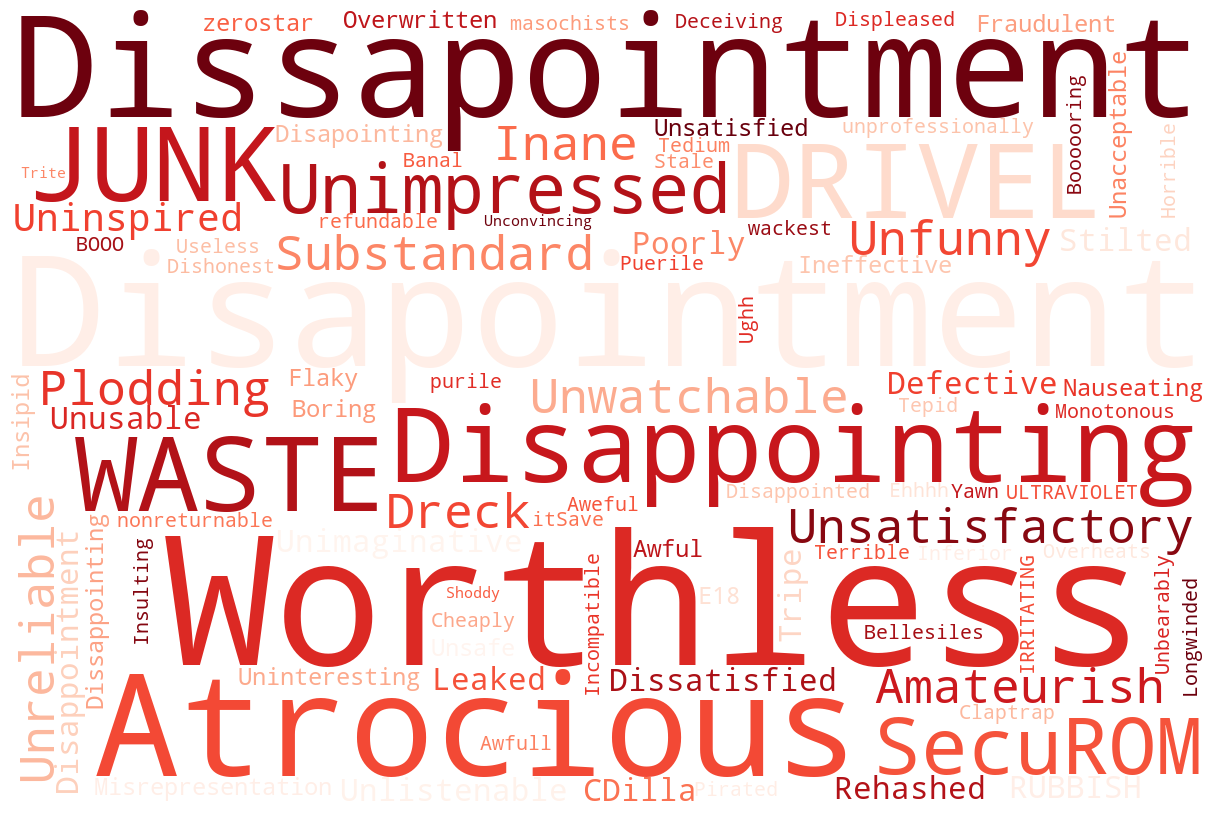

In [33]:
# Generate a word cloud image for NEGATIVITY
wordcloud = WordCloud(colormap = "Reds", background_color="white", width = 1200, height = 800,).generate(negativity_text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize = (12, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

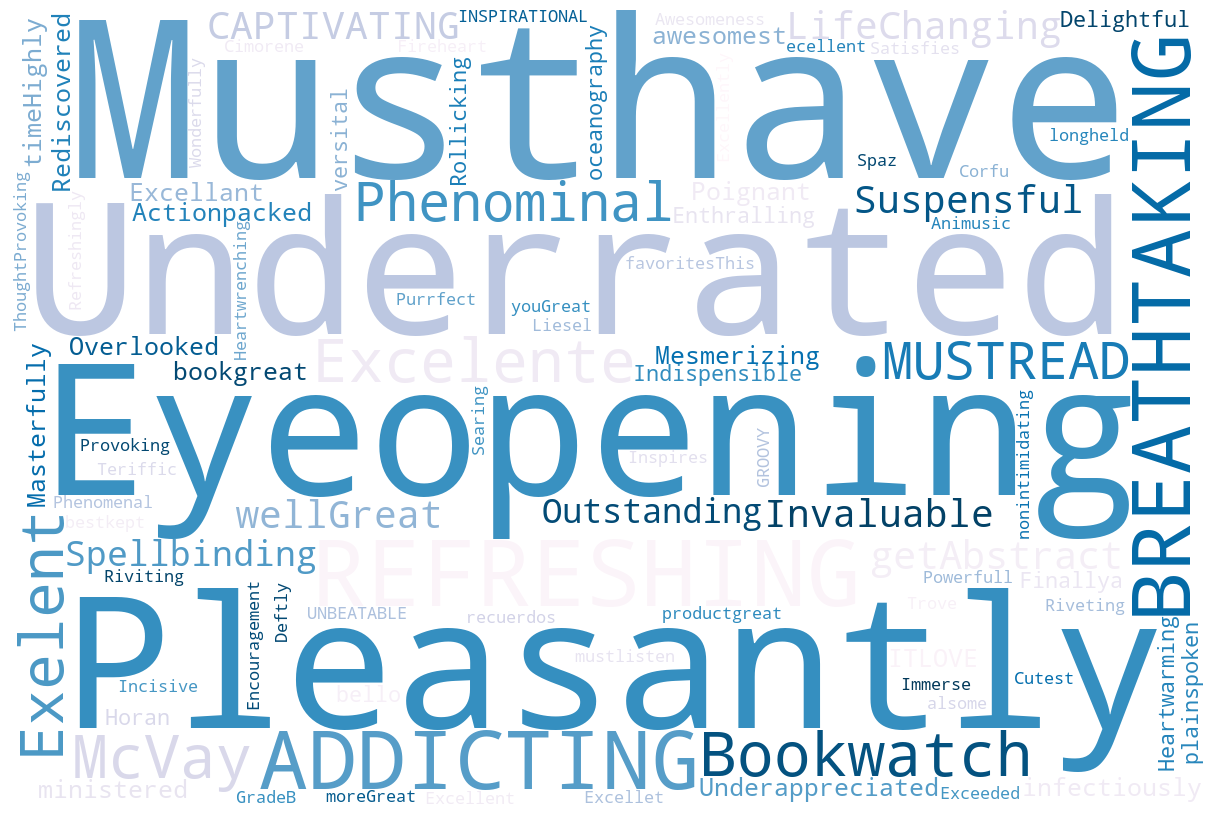

In [34]:
# Generate a word cloud image for POSITIVITY
wordcloud = WordCloud(colormap = "PuBu", background_color="white", width = 1200, height = 800,).generate(positivity_text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize = (12, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

### Tarefa desafio!

Qual o desempenho do classificador (acurácia)? Para medir sua acurácia:

- Separe os reviews em dois conjuntos: treinamente e teste
- Repita o "treinamento" do classificador com o conjunto de treinamento
- Para cada review do conjunto de teste, determine se é positiva ou negativa de acordo com o classificador
- Determine a acurácia

Esta não é uma tarefa trivial. Não basta fazer um `for` para determinar a classe de cada review de teste: isso demoraria uma eternidade. Você tem que usar variáveis "broadcast" do Spark para enviar uma cópia da tabela de frequencias para cada *core* do executor.

No PySpark RDD e DataFrame, as variáveis de `broadcast` são variáveis _read-only_ que são armazenadas em cache e disponíveis em todos os nós em um cluster para acessar ou usar pelas _tasks_. Em vez de enviar esses dados junto com cada tarefa, o PySpark distribui variáveis `broadcast` para os _workers_ usando algoritmos de transmissão eficientes para reduzir os custos de comunicação.

Logo, em vez de distribuir essas informações junto com cada _tasks_ pela rede (sobrecarga e demorado), podemos usar a variável de `broadcast` para armazenar em cache essas informações de pesquisa em cada máquina e as _tasks_ usam essas informações armazenadas em cache enquanto executam as transformações.

In [90]:
test, train = rdd.randomSplit(weights=[0.2, 0.8], seed=23)

In [91]:
# Separando em sentimentos 1 e 2
train_negative_rdd = train.filter(lambda x: x[0] == 1)
train_positive_rdd = train.filter(lambda x: x[0] == 2)

# Contando as palavras
train_negative_word_count = count_word(negative_rdd)
train_positive_word_count = count_word(positive_rdd)

# Calculando a probabilidade
train_neg_rdd = count_log(negative_word_count)
train_pos_rdd = count_log(positive_word_count)    

In [92]:
# Rearranjando em (palavra, log_prob_positivo, log_prob_negativo) 
train_unified_rdd =  train_neg_rdd \
                .fullOuterJoin(train_pos_rdd) \
                .map(lambda x: (x[0], (x[1][1], x[1][0])))
train_pos_neg_map = train_unified_rdd.collectAsMap()

In [93]:
train_unified_rdd.take(10)

[('family', (-3.3543939677236634, -3.807023215978198)),
 ('belief', (-4.780224783795587, -4.665473902486612)),
 ('out', (-2.5897644969597597, -2.5264979053685646)),
 ('immediateHere', (None, -8.16474848437883)),
 ('timbre', (-5.927127653723786, -6.25626346550018)),
 ('24', (-4.444432681872394, -4.331856539619039)),
 ('unitThe', (-6.423677460281774, -6.16911328978128)),
 ('kinda', (-4.365355659949695, -4.402670397044191)),
 ('flour', (-5.159508045491933, -5.087017304726438)),
 ('Stars', (-4.508101761741771, -4.657702611951504))]

In [94]:
# Associando o train_pos_neg_list à uma var broadcast
bc_train_pos_neg_map = sc.broadcast(train_pos_neg_map)

In [95]:
bc_train_pos_neg_map.value['start']

(-3.506996488996986, -3.58927197577693)

In [96]:
def naive_bayes_v2(review, pos_neg):
    title, body = remove_ponctuation(review)
    corpus = title.split() + body.split()
    pos = 0
    neg = 0
    for word in corpus:
        pos_neg_dict = pos_neg.value
        if word in pos_neg_dict:
            if pos_neg_dict[word][0] != None:
                pos += pos_neg_dict[word][0]
            if pos_neg_dict[word][1] != None:
                neg += pos_neg_dict[word][1]
    if pos > neg:
        return 2
    else:
        return 1

In [97]:
from functools import partial

Naive_Bayes_bp = partial(naive_bayes_v2, pos_neg = bc_train_pos_neg_map)


# (predicted, true_value)
predictions = test\
                    .map(lambda x: (x[0], remove_ponctuation(x)[0], remove_ponctuation(x)[1])) \
                    .map(lambda x: (x[0], x[1] + x[2])) \
                    .map(lambda x: (Naive_Bayes_bp(review = x[1]), x[0]))

In [98]:
predictions.take(3)

[(1, 2), (2, 2), (2, 1)]

In [99]:
guessed_right = predictions \
            .filter(lambda x: x[0] == x[1])

In [100]:
#Com o .count() estourava a memória
guessed_right = sc.broadcast(guessed_right.collect())
predictions = sc.broadcast(predictions.collect())

In [101]:
num_guessed_right = len(guessed_right.value)
total_size = len(predictions.value)

accuracy = num_guessed_right/total_size

print(f"A acurácia foi de {accuracy*100}%")

A acurácia foi de 49.73098385625443%


### Tarefa desafio!

Implemente Laplace smoothing

## Rubrica de avaliação

- I: groselha, falha crítica, ou não entregou nada
- D: Fez uma tentativa honesta de fazer todos os itens da fase 1, mas tem erros
- C: Fase 1 completa
- B: Fase 2, faltando apenas um desafio
- A: Fase 2 completa